In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from pathlib import Path
import random
from PIL import Image
from google.colab import drive

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
input_dir = Path("/content/drive/MyDrive/malaria")
output_dir = Path("/content/drive/MyDrive/Malaria_aug")
output_dir.mkdir(exist_ok=True)

# Augmentations
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
])

for class_name in os.listdir(input_dir):
    class_input = input_dir / class_name
    class_output = output_dir / class_name
    class_output.mkdir(exist_ok=True)

    print(f"Augmenting class: {class_name}")

    for img_name in os.listdir(class_input):
        img_path = class_input / img_name

        try:
            img = Image.open(img_path).convert("RGB")

            # save original
            img.save(class_output / img_name)

            # Generate 3 augmentations
            for i in range(3):
                new_img = augmentation_transforms(img)
                new_name = f"{img_name.split('.')[0]}_aug{i}.jpg"
                new_img.save(class_output / new_name)

        except Exception as e:
            print(f"Error with {img_name}: {e}")

Augmenting class: Vivax
Augmenting class: Ovalae
Augmenting class: Falciparum
Augmenting class: Malariae
Augmenting class: Uninfected


In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

# 80/20 split
train_dir = Path("/content/drive/MyDrive/Malaria_aug")
val_dir = Path("/content/drive/MyDrive/Malaria_aug")   # we will split manually

dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []

In [ ]:
train_losses, val_losses = [], []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0

    # ------- TRAINING --------
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # ------- VALIDATION --------
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_losses[-1]:.4f} | "
        f"Val Loss: {val_losses[-1]:.4f} | "
        f"Train Acc: {train_accuracy:.4f} | "
        f"Val Acc: {val_accuracy:.4f}"
    )

Epoch 1/10 | Train Loss: 0.6466 | Val Loss: 2.6619 | Train Acc: 0.7925 | Val Acc: 0.5676
Epoch 2/10 | Train Loss: 0.2203 | Val Loss: 4.0426 | Train Acc: 0.9303 | Val Acc: 0.6419
Epoch 3/10 | Train Loss: 0.2064 | Val Loss: 0.2187 | Train Acc: 0.9354 | Val Acc: 0.8986
Epoch 4/10 | Train Loss: 0.1432 | Val Loss: 1.7254 | Train Acc: 0.9575 | Val Acc: 0.7432
Epoch 5/10 | Train Loss: 0.4032 | Val Loss: 1.4221 | Train Acc: 0.8827 | Val Acc: 0.5743
Epoch 6/10 | Train Loss: 0.1677 | Val Loss: 0.3496 | Train Acc: 0.9473 | Val Acc: 0.8919
Epoch 7/10 | Train Loss: 0.1300 | Val Loss: 0.0796 | Train Acc: 0.9558 | Val Acc: 0.9730
Epoch 8/10 | Train Loss: 0.1084 | Val Loss: 0.1452 | Train Acc: 0.9660 | Val Acc: 0.9595
Epoch 9/10 | Train Loss: 0.1333 | Val Loss: 0.7870 | Train Acc: 0.9490 | Val Acc: 0.7905
Epoch 10/10 | Train Loss: 0.0748 | Val Loss: 0.2244 | Train Acc: 0.9813 | Val Acc: 0.9054


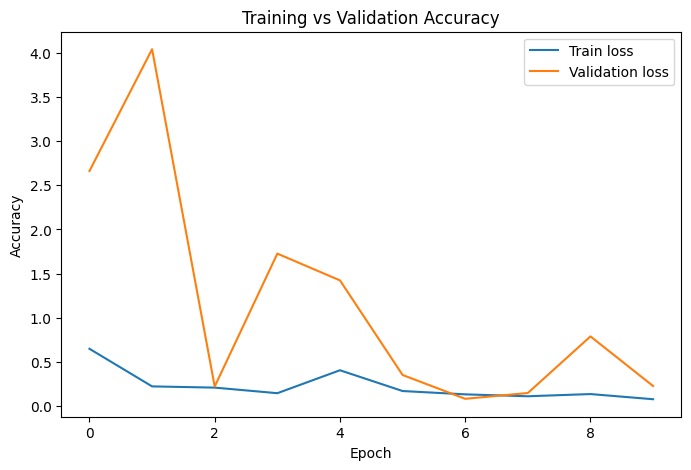

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

<Figure size 800x800 with 0 Axes>

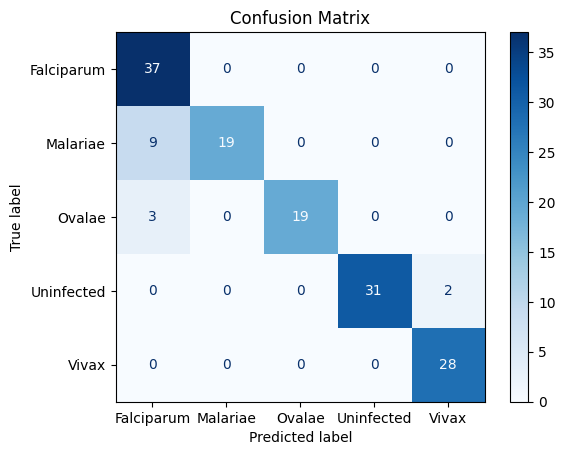

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8,8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/resnet_malaria.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/resnet_malaria.pth
